# Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from math import ceil
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score

In [2]:
try:
    import opendatasets as od
except ModuleNotFoundError:
    os.system('pip install opendatasets')
    import opendatasets as od

In [3]:
%matplotlib inline

# Data ingestion

In [6]:
# if not os.path.exists(DATA_DIR):
#     dataset_url = 'https://www.kaggle.com/c/jovian-pytorch-z2g/'
#     od.download(dataset_url)

In [41]:
DATA_DIR = 'web_app/Human_protein_atlas'

In [5]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')

In [6]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [13]:
# len(data_df)

19236

# Datasets & Dataloaders

## Images stats

In [7]:
class ImageDS(Dataset):
    
    def __init__(self, root, df):
        super(ImageDS, self).__init__()
        self.root = root
        self.df = df
        self.transform = transforms.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.Image.loc[idx]
        img_path = os.path.join(self.root, str(img_name)+'.png')
        img = Image.open(img_path).convert('RGB')
        return self.transform(img)

In [8]:
image_ds = ImageDS(TRAIN_DIR, data_df)

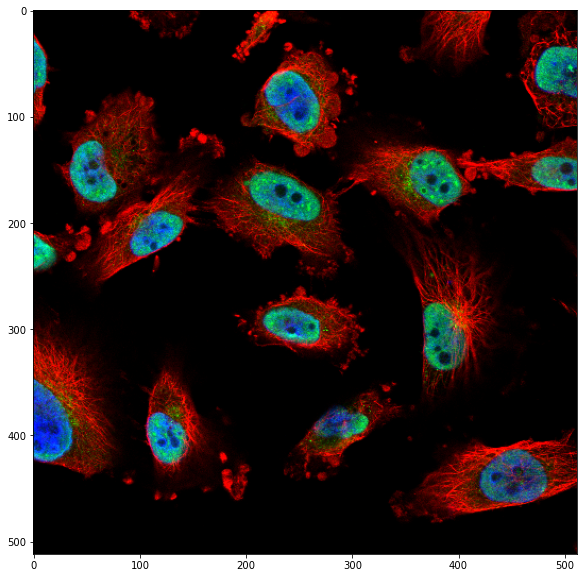

In [34]:
# plt.figure(figsize=(10,10))
# plt.imshow(image_ds[2].permute(1,2,0))

In [11]:
image_dl = DataLoader(image_ds, batch_size=1024, num_workers=4, pin_memory=True)

In [12]:
img_means_list = []
for imgs in tqdm(image_dl):
    img_means_list.append(imgs.to(device=torch.device('cuda'), non_blocking=True).sum(dim=(0, 2, 3)))

In [13]:
img_means = torch.stack(img_means_list).sum(dim=0) / (len(image_ds) * 512 * 512)

In [15]:
img_vars_list = []
for imgs in tqdm(image_dl):
    img_vars_list.append(((imgs.cuda(non_blocking=True)-img_means.reshape(1, 3, 1, 1))**2).sum(dim=(0, 2, 3)))

In [16]:
img_vars = torch.stack(img_vars_list).sum(dim=0) / (len(image_ds) * 512 * 512)

In [17]:
img_stds = torch.sqrt(img_vars)

In [18]:
img_means.tolist(), img_stds.tolist()

([0.07927913218736649, 0.0530361607670784, 0.05445904657244682],
 [0.14870058000087738, 0.1128898411989212, 0.15560144186019897])

## Data augmentation

In [7]:
img_stats = ([0.07927913218736649, 0.0530361607670784, 0.05445904657244682], [0.14870058000087738, 0.1128898411989212, 0.15560144186019897])

In [8]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*img_stats)
])

train_transforms = transforms.Compose([
    transforms.RandomCrop(512, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(*img_stats)
])

## Datasets

In [9]:
idx_to_label = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [10]:
def encode_label(label):
    '''Encodes a string of labels as a one-hot vector, eg:
    >>> encode_label('6 1 4')
    torch.tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0])
    '''
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1
    return target

In [12]:
# thresholds = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.739, 0.5, 0.5, 0.5, 0.5, 0.5])
# thresholds = torch.tensor([0.21, 0.2, 0.29, 0.32, 0.52, 0.14, 0.35, 0.31, 0.22, 0.08])
# thresholds = torch.tensor([0.21, 0.242, 0.494, 0.32, 0.739, 0.23, 0.35, 0.31, 0.22, 0.321]) # compt
# thresholds = torch.tensor([0.47499999, 0.52700001, 0.597, 0.29699999, 0.99900001,0.69300002, 0.98400003, 0.54000002, 0.001, 0.057]) # train
# thresholds = torch.tensor([0.866, 0.28, 0.95, 0.27599999, 0.52200001, 0.45899999, 0.68699998, 0.81699997, 0.75999999, 0.61299998]) # val
thresholds = torch.tensor([0.118, 0.81199998, 0.94700003, 0.126, 0.117,0.72399998, 0.047, 0.87400001, 0.99000001, 0.84799999]) # model_3 epoch 25 val

In [53]:
def decode_labels(probs, threshold):
    probs = probs.detach()
    decoded_labels = probs >= threshold
    decoded_labels = torch.arange(10)[decoded_labels]
    if decoded_labels.shape == (0,):
        decoded_labels = probs.argmax(dim=-1, keepdim=True)
    decoded_labels = decoded_labels.cpu().numpy().astype('<U1').tolist()    
    return ' '.join(decoded_labels)

In [14]:
val_perct = 0.1

In [15]:
random_seed = 314

np.random.seed(random_seed)
data_df = data_df.sample(frac=1).reset_index(drop=True)

val_size = int(val_perct * len(data_df))

val_df = data_df[:val_size].reset_index(drop=True)
train_df = data_df[val_size:].reset_index(drop=True)

### Oversampling (SMOTE)

In [15]:
# {i: train_df.Label.str.contains(f'{i}').sum() for i in range(10)}

{0: 1881,
 1: 1564,
 2: 2284,
 3: 1765,
 4: 8178,
 5: 1019,
 6: 5136,
 7: 2365,
 8: 934,
 9: 1158}

In [16]:
train_df.drop(train_df[train_df.Label == '4'].iloc[:1200].index, inplace=True)

train_df.drop(train_df[train_df.Label.str.contains(' 4')].iloc[:800].index, inplace=True)

df = train_df.copy()

tmp_df = train_df[(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('4'))]
for i in range(6):
    df = df.append(tmp_df)

tmp_df = train_df[(train_df.Label.str.contains('5')) & ~(train_df.Label.str.contains('4')) & ~(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('6'))]
for i in range(6):
    df = df.append(tmp_df)

tmp_df = train_df[(train_df.Label.str.contains('9')) & ~(train_df.Label.str.contains('4')) & ~(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('5')) & ~(train_df.Label.str.contains('6'))]
for i in range(3):
    df = df.append(tmp_df)

tmp_df = train_df[(train_df.Label.str.contains('1')) & ~(train_df.Label.str.contains('4')) & ~(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('5')) & ~(train_df.Label.str.contains('6')) & ~(train_df.Label.str.contains('9'))]
for i in range(3):
    df = df.append(tmp_df)

tmp_df = train_df[(train_df.Label.str.contains('3')) & ~(train_df.Label.str.contains('4')) & ~(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('5')) & ~(train_df.Label.str.contains('6')) & ~(train_df.Label.str.contains('9')) & ~(train_df.Label.str.contains('1'))]
for i in range(2):
    df = df.append(tmp_df)

tmp_df = train_df[(train_df.Label.str.contains('0')) & ~(train_df.Label.str.contains('4')) & ~(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('5')) & ~(train_df.Label.str.contains('6')) & ~(train_df.Label.str.contains('9')) & ~(train_df.Label.str.contains('1')) & ~(train_df.Label.str.contains('3'))]
for i in range(1):
    df = df.append(tmp_df)

df = df.append(tmp_df.iloc[:700])

tmp_df = train_df[(train_df.Label.str.contains('2')) & ~(train_df.Label.str.contains('4')) & ~(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('5')) & ~(train_df.Label.str.contains('6')) & ~(train_df.Label.str.contains('9')) & ~(train_df.Label.str.contains('1')) & ~(train_df.Label.str.contains('3')) & ~(train_df.Label.str.contains('0'))]
for i in range(2):
    df = df.append(tmp_df)

tmp_df = train_df[(train_df.Label.str.contains('7')) & ~(train_df.Label.str.contains('4')) & ~(train_df.Label.str.contains('8')) & ~(train_df.Label.str.contains('5')) & ~(train_df.Label.str.contains('6')) & ~(train_df.Label.str.contains('9')) & ~(train_df.Label.str.contains('1')) & ~(train_df.Label.str.contains('3')) & ~(train_df.Label.str.contains('0')) & ~(train_df.Label.str.contains('2'))]
for i in range(1):
    df = df.append(tmp_df)

In [17]:
random_seed = 31415

np.random.seed(random_seed)
train_df = df.sample(frac=1).reset_index(drop=True)

In [122]:
# {i: train_df.Label.str.contains(f'{i}').sum() for i in range(10)}

{0: 4032,
 1: 4006,
 2: 4041,
 3: 3780,
 4: 6149,
 5: 4259,
 6: 5437,
 7: 3952,
 8: 4119,
 9: 3876}

In [16]:
# len(train_df)

32782

In [15]:
# val_df.to_csv(os.path.join(DATA_DIR, 'val.csv'))

In [18]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        super().__init__()
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id, label = row['Image'], row['Label']
        img_path = os.path.join(self.root_dir, str(img_id) + ".png")
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

In [19]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_transforms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=val_transforms)

In [20]:
def denormalize(img, img_stats=img_stats):
    mean = torch.tensor(img_stats[0]).reshape(3, 1, 1)
    std = torch.tensor(img_stats[1]).reshape(3, 1 ,1)
    return (img * std) + mean

Labels : Nucleoplasm, Nucleoli fibrillar center,


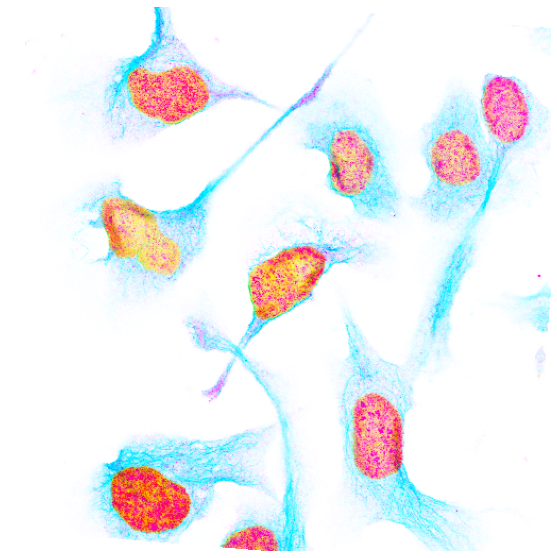

In [44]:
# show_sample(*train_ds[1], invert=True)

## DataLoaders

In [21]:
batch_size = 128+32-8-64 # top
# batch_size = 128-32-16-16-16-8 # resnext_6_-6
# batch_size = 128-32-16-32-16-8 # resnext_6_-12
# batch_size = 128-32-16-32-16-8-8 # resnext_6_-18

In [22]:
train_dl = DataLoader(train_ds, 
                      batch_size = batch_size, 
                      shuffle = True, 
                      num_workers = 4, 
                      pin_memory = True)

val_dl = DataLoader(val_ds, 
                    batch_size = batch_size, 
                    num_workers = 4, 
                    pin_memory = True)

In [23]:
def show_batch(batch_images, nmax=64):
    batch_images = denormalize(batch_images[:nmax])
    grid = make_grid(batch_images, nrow=8)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')

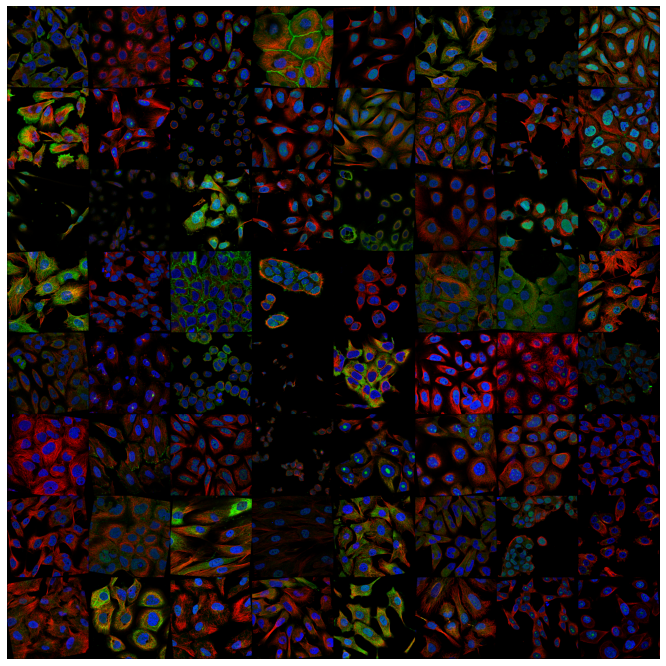

In [48]:
# show_batch(next(iter(train_dl))[0])

# Model with attention

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
use_amp = True

In [26]:
class ModelWithAttention(nn.Module):
    
    def __init__(self):
        super().__init__()
        resnext = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x8d_swsl')
        self.resnext = nn.Sequential(*list(resnext.children())[:-3])
        self.resnext.requires_grad_(False)
        self.dropout = nn.Dropout(0.25)
        self.attention_nn = nn.Sequential(
            nn.Linear(1024, 10),
            nn.Softmax(dim=1)
        )
        self.multi_label_classifier = nn.Conv1d(10, 10, kernel_size=1024, groups=10)
        self.top = nn.ModuleList([self.attention_nn, self.multi_label_classifier])
    
    @amp.autocast(enabled=use_amp)
    def forward(self, imgs):
        encoded_imgs = self.resnext(imgs) # shape : batch_size x 2048 x H x W 
        encoded_imgs = encoded_imgs.reshape(*encoded_imgs.shape[:2], -1).swapaxes(1, 2) # shape: batch_size x (HxW) x 2048
        encoded_imgs = self.dropout(encoded_imgs)
        weights = self.attention_nn(encoded_imgs) # shape: batch_size x (HxW) x 10
        encoded_imgs = encoded_imgs.unsqueeze(dim=1).repeat(1, 10, 1, 1) # shape: batch_size x 10 x (HxW) x 2048
        weights = weights.swapaxes(1, 2).unsqueeze(dim=-1) # shape: batch_size x 10 x (HxW) x 1
        outputs = weights * encoded_imgs # shape: batch_size x 10 x (HxW) x 2048
        outputs = outputs.sum(dim=2) # shape: batch_size x 10 x 2048
        outputs = self.multi_label_classifier(outputs).squeeze() # shape: batch_size x 10 x 1 => batch_size x 10 (after squeezing)
        return outputs, weights

In [27]:
model = ModelWithAttention()

Using cache found in /home/bkaroui/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [28]:
model.to(device);

In [29]:
model.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/model_epoch_25.pth'))

<All keys matched successfully>

In [71]:
# evaluate(model, val_dl)

(0.1849854290485382,
 0.7126631140708923,
 0.8231821060180664,
 0.6298550963401794)

# Training

## Metric

In [30]:
thresholds = thresholds.to(device)

In [31]:
@torch.no_grad()
@amp.autocast(enabled=False)
def F_score(output, label, threshold=thresholds, beta=1):
    prob = torch.sigmoid(output) > threshold
    label = label > threshold

    TP = (prob & label).sum(dim=0)
    TN = ((~prob) & (~label)).sum(dim=0)
    FP = (prob & (~label)).sum(dim=0)
    FN = ((~prob) & label).sum(dim=0)

    precision = torch.mean(TP / (TP + FP + 1e-8))
    recall = torch.mean(TP / (TP + FN + 1e-8))
    F = ((1 + (beta**2)) * precision * recall) / ((beta**2) * precision + recall + 1e-8)
    assert len(F.shape) == 0
    return F, precision, recall

## Evaluation Loop

In [32]:
@amp.autocast(enabled=use_amp)
@torch.no_grad()
def evaluate(model, val_dl):
    torch.cuda.empty_cache()
    model.eval()
    losses = []
    scores = []
    precisions = []
    recalls = []
    with tqdm(val_dl, unit = ' batches', desc = "Val set ") as batch_loader:
        for imgs, targets in batch_loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs, _ = model(imgs)
            loss = F.binary_cross_entropy_with_logits(outputs, targets)
            score, precision, recall = F_score(outputs, targets)
            losses.append(loss)
            scores.append(score)
            precisions.append(precision)
            recalls.append(recall)
        loss = torch.stack(losses).mean().item()
        score = torch.stack(scores).mean().item()
        precision = torch.stack(precisions).mean().item()
        recall = torch.stack(recalls).mean().item()
        batch_loader.set_postfix(val_loss = f'{loss:.4f}', 
                                 val_score=f'{score:.2%}')
    return loss, score, precision, recall

## Training Loop

In [33]:
epoch_counter = 0

In [34]:
os.makedirs('./web_app/model_checkpoints/model_3/', exist_ok=True)

In [35]:
def fit(model, train_dl, val_dl, optimizer, scaler, lr, epochs, sched=None, grad_clip_norm=1, iters_to_accumulate=1):
    
    global epoch_counter
    
    train_losses = []
    val_losses = []
    # train_scores = []
    val_scores = []
    
    steps_per_epoch = ceil(len(train_dl)/iters_to_accumulate)
    
    if sched is None:
        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=steps_per_epoch)
        
    for epoch in range(epochs):
        
        model.train()
        epoch_losses = []
        # epoch_scores = []
        batch_loss = 0.
        
        with tqdm(enumerate(train_dl), unit=' batches', desc=f"Epoch {epoch+1} ", total=len(train_dl)) as batch_loader:
            for i, (imgs, targets) in batch_loader:
                imgs = imgs.to(device)
                targets = targets.to(device)
                outputs, _ = model(imgs)
                
                with amp.autocast(enabled=use_amp):
                    loss = F.binary_cross_entropy_with_logits(outputs, targets)
                    loss /= iters_to_accumulate

                scaler.scale(loss).backward()
                batch_loss += loss.detach()
                
                if ((i + 1) % iters_to_accumulate == 0) or (i + 1 == len(train_dl)):
                    
                    epoch_losses.append(batch_loss)
                    batch_loss = 0.
                    
                    scaler.unscale_(optimizer)
                    if grad_clip_norm:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    sched.step() 
                
                # epoch_losses.append(loss.detach())
                
                # score = F_score(outputs, targets)
                # epoch_scores.append(score.detach())            
            
            train_losses.append(torch.stack(epoch_losses).mean().item())
            # train_scores.append(torch.stack(epoch_scores).mean().item())
            val_loss, val_score, _, _ = evaluate(model, val_dl)
            val_losses.append(val_loss)
            val_scores.append(val_score)
            
            batch_loader.container.children[-2].style.bar_color = 'green'
            batch_loader.set_postfix(train_loss=f'{train_losses[-1]:.4f}', # train_score=f'{train_scores[-1]:.2%}' 
                                     )
        
        epoch_counter += 1
        # torch.save(model.top.state_dict(), f'./web_app/model_checkpoints/model_top_epoch_{epoch_counter}.pth')
        torch.save(model.state_dict(), f'./web_app/model_checkpoints/model_3/model_epoch_{epoch_counter}.pth')
        torch.save(optimizer.state_dict(), f'./web_app/model_checkpoints/model_3/optimizer_epoch_{epoch_counter}.pth')
        torch.save(scaler.state_dict(), f'./web_app/model_checkpoints/model_3/scaler_epoch_{epoch_counter}.pth')
        
    return train_losses, val_losses, val_scores #, train_scores

## Finding best learning rate

In [93]:
def find_lr(model, train_dl, init_value=1e-8, final_value=10., beta=0.98, grad_clip=None):
        
    import math
    
    num = len(train_dl)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    # optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
    avg_loss = 0.
    best_loss = 1000000.
    batch_num = 0
    losses = []
    log_lrs = []
    
    scaler = amp.GradScaler(enabled=use_amp)
    torch.cuda.empty_cache()
    for imgs, targets in tqdm(train_dl):
        
        batch_num += 1
        optimizer.zero_grad()
        imgs = imgs.to(device)
        targets = targets.to(device)
        #As before, get the loss for this mini-batch of inputs/outputs
        outputs, _ = model(imgs)
        with amp.autocast(enabled=use_amp):
            loss = F.binary_cross_entropy_with_logits(outputs, targets)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.detach().item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [94]:
logs, losses = find_lr(model, train_dl, grad_clip=1)

<ipython-input-93-52e4a2b71c36>:44: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(model.parameters(), grad_clip)


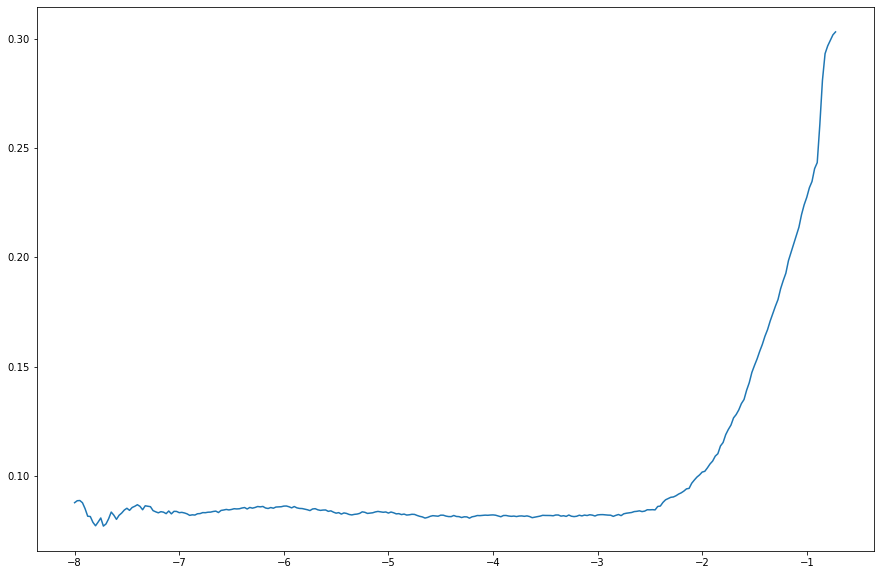

In [95]:
plt.figure(figsize=(15, 10))
plt.plot(logs[:-2],losses[:-2])

## Training phase

In [34]:
assert torch.backends.cudnn.enabled == True
torch.backends.cudnn.benchmark = True

In [35]:
lr = 0.003
epochs = 10

In [36]:
optimizer = torch.optim.AdamW(model.top.parameters(), lr=lr, weight_decay=0.01)

In [37]:
scaler = amp.GradScaler(enabled=use_amp)

In [38]:
epoch_counter = 0

In [39]:
history = fit(model, train_dl, val_dl, optimizer, scaler, lr, epochs, iters_to_accumulate=3)

/home/bkaroui/anaconda3/envs/pytorch-full/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-1_ic8ial/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


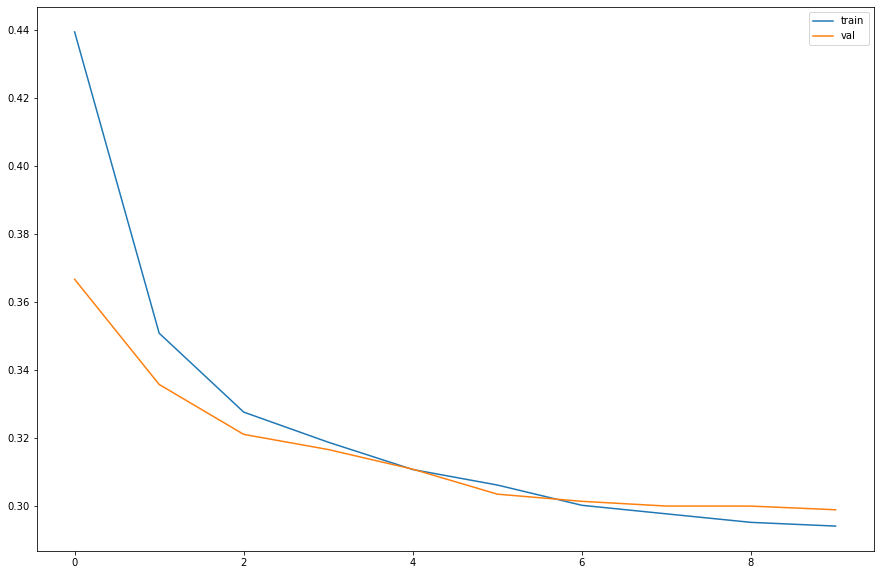

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(history[0], label='train')
plt.plot(history[1], label='val')
plt.legend()

In [40]:
model.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/model_epoch_10.pth'))

<All keys matched successfully>

In [40]:
model.top.requires_grad_(True);

In [41]:
model.resnext[6][-6:].requires_grad_(True);

In [42]:
lr_1 = 3e-3
lr_2 = 1e-4

In [43]:
optimizer.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/optimizer_epoch_10.pth'))

In [44]:
optimizer.add_param_group({'params':model.resnext[6][-6:].parameters(), 'lr': lr_2})

In [45]:
scaler.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/scaler_epoch_10.pth'))

In [46]:
epoch_counter = 10

In [47]:
history2 = fit(model, train_dl, val_dl, optimizer, scaler, [lr_1, lr_2], epochs=5, iters_to_accumulate=4)

/home/bkaroui/anaconda3/envs/pytorch-full/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-1_ic8ial/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [41]:
model.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/model_epoch_15.pth'))

<All keys matched successfully>

In [42]:
model.top.requires_grad_(True);

In [43]:
model.resnext[6][-6:].requires_grad_(True);

In [44]:
model.resnext[6][-12:-6].requires_grad_(True);

In [45]:
lr_1 = 1e-3
lr_2 = 8e-4
lr_3 = 6e-4

In [46]:
optimizer.add_param_group({'params':model.resnext[6][-6:].parameters(), 'lr': lr_2})

In [47]:
optimizer.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/optimizer_epoch_15.pth'))

In [48]:
optimizer.add_param_group({'params':model.resnext[6][-12:-6].parameters(), 'lr': lr_3})

In [49]:
scaler.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/scaler_epoch_15.pth'))

In [50]:
epoch_counter = 15

In [51]:
history3 = fit(model, train_dl, val_dl, optimizer, scaler, [lr_1, lr_2, lr_3], epochs=5, iters_to_accumulate=6)

/home/bkaroui/anaconda3/envs/pytorch-full/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-1_ic8ial/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [39]:
model.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/model_epoch_20.pth'))

<All keys matched successfully>

In [40]:
model.top.requires_grad_(True);

In [41]:
model.resnext[6][-6:].requires_grad_(True);

In [42]:
model.resnext[6][-12:-6].requires_grad_(True);

In [43]:
model.resnext[6][-18:-12].requires_grad_(True);

In [44]:
lr_1 = 5e-4
lr_2 = 8e-4
lr_3 = 6e-4
lr_4 = 4e-4

In [45]:
optimizer.add_param_group({'params':model.resnext[6][-6:].parameters(), 'lr': lr_2})

In [46]:
optimizer.add_param_group({'params':model.resnext[6][-12:-6].parameters(), 'lr': lr_3})

In [47]:
optimizer.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/optimizer_epoch_20.pth'))

In [48]:
optimizer.add_param_group({'params':model.resnext[6][-18:-12].parameters(), 'lr': lr_4})

In [49]:
scaler.load_state_dict(torch.load('./web_app/model_checkpoints/model_3/scaler_epoch_20.pth'))

In [50]:
epoch_counter = 20

In [51]:
history4 = fit(model, train_dl, val_dl, optimizer, scaler, [lr_1, lr_2, lr_3, lr_4], epochs=5, iters_to_accumulate=10)

/home/bkaroui/anaconda3/envs/pytorch-full/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-1_ic8ial/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Finding best thresholds

In [54]:
@torch.no_grad()
@amp.autocast(enabled=use_amp)
def out_targets(model, data_loader):
    torch.cuda.empty_cache()
    out = []
    targets = []
    for imgs, y in tqdm(data_loader):
        imgs = imgs.to(device)
        y = y.to(device)
        model.eval()
        out.append(model(imgs)[0])
        targets.append(y)
    out = torch.cat(out)
    out = out.cpu().numpy()
    targets = torch.cat(targets).cpu().numpy()
    return out, targets

In [55]:
def find_thresholds(out, targets):
    best_thresholds = np.zeros(10)
    for i in range(10):
        thresholds = np.linspace(0.001, 0.999, num=999, dtype=np.float32)
        F1 = []
        for thresh in thresholds:
            labels = out[:, i]
            labels = 1*(labels >= thresh)
            F1.append([thresh, fbeta_score(targets[:, i], labels, beta=0.6)])
        best_thresholds[i] = max(F1, key=lambda x: x[1])[0]
        
    return best_thresholds

In [33]:
outputs, targets = out_targets(model, train_dl)

/home/bkaroui/anaconda3/envs/pytorch-full/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-1_ic8ial/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [62]:
outputs_val, targets_val = out_targets(model, val_dl)

In [34]:
best_thresholds = find_thresholds(outputs, targets)

In [35]:
best_thresholds

array([0.67400002, 0.41100001, 0.67900002, 0.68900001, 0.65100002,
       0.972     , 0.64499998, 0.50599998, 0.15800001, 0.45100001])

In [63]:
find_thresholds(outputs_val, targets_val)

array([0.98199999, 0.866     , 0.65399998, 0.147     , 0.016     ,
       0.001     , 0.021     , 0.042     , 0.95200002, 0.801     ])

# Visualiazing the attention mask

In [36]:
os.makedirs('./web_app/tmp_predictions', exist_ok=True)

In [37]:
def visualize_att_mask(img_path, df, model, root_path, device=device, threshold=thresholds):
    
    tmp_files = os.listdir(root_path)
    for file in tmp_files:
        path = os.path.join(root_path, file)
        if os.path.isfile(path):
            os.remove(path)
            
    img_name = img_path.split('/')[-1][:-4]
    targets = df.loc[df.Image == int(img_name)].Label.str.split().tolist()
    img = Image.open(img_path).convert('RGB')
    img_to_tensor = transforms.ToTensor()
    img = img_to_tensor(img)
    img = img.unsqueeze(dim=0).to(device) # shape : 1 x 3 x 512 x 512
    with torch.no_grad():
        with amp.autocast(enabled=use_amp):
            model.eval()
            logits, weights = model(img)
            probs = torch.sigmoid(logits)
    labels = probs >= threshold
    labels = torch.arange(10)[labels]
    if labels.shape == (0,):
        labels = probs.argmax(dim=-1, keepdim=True)
    labels = labels.cpu()
    weights = weights.squeeze()[labels].unsqueeze(dim=0).reshape(1, labels.shape[0], 32, 32).cpu()
    upsampled_weights = F.upsample(weights, size=512, mode='bilinear')
    img = img.cpu()
    for i, protein_idx in enumerate(labels):
        idx = protein_idx.item()
        fig = plt.figure(figsize=(13, 13))
        plt.imshow(img[0].permute(1, 2, 0), cmap='Greys_r')
        plt.imshow(upsampled_weights[0, i, :, :], cmap='Greys_r', alpha=0.6)
        plt.axis('off')
        plt.savefig(os.path.join(root_path, f'protein_{idx}.png'), bbox_inches='tight')
        # plt.close(fig)
    return probs.tolist(), labels.tolist(), targets[0]

([0.012725830078125,
  0.00809478759765625,
  0.9365234375,
  0.007175445556640625,
  0.9658203125,
  0.0245208740234375,
  0.34619140625,
  0.048675537109375,
  0.01214599609375,
  0.00945281982421875],
 [4, 6],
 ['2', '4'])

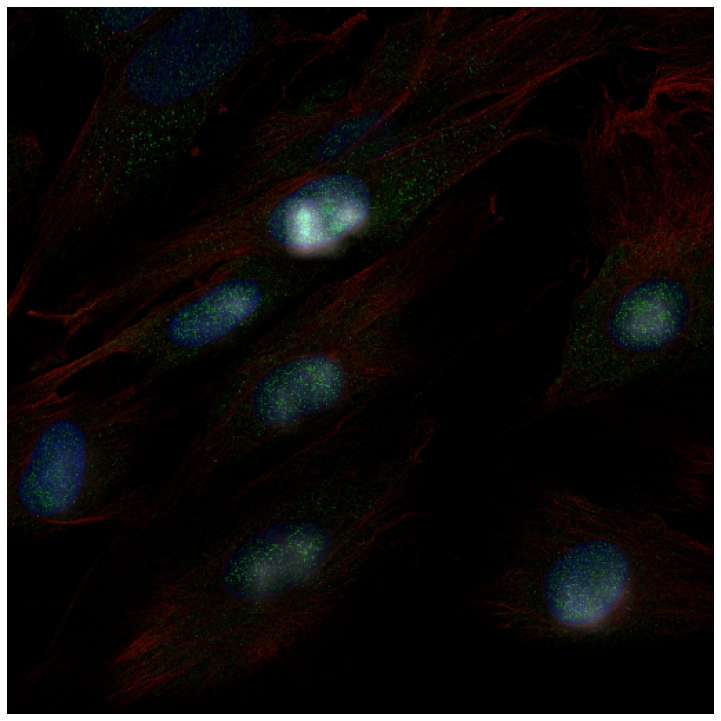

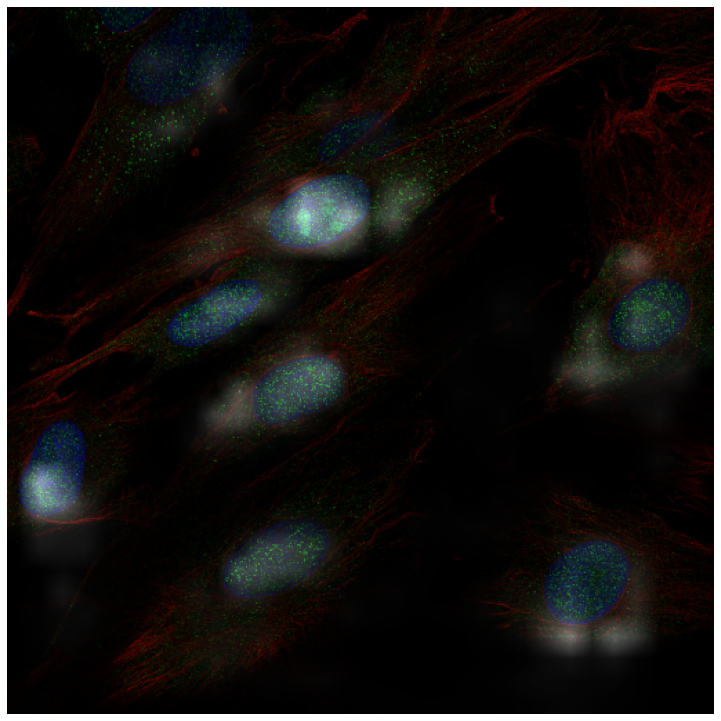

In [60]:
visualize_att_mask('./web_app/Human_protein_atlas/train/13622.png', data_df, model, './web_app/tmp_predictions', threshold=thresholds)

# Submission

In [42]:
TEST_CSV = os.path.join(DATA_DIR, 'submission.csv')

In [45]:
test_df = pd.read_csv(TEST_CSV)
test_ds = HumanProteinDataset(test_df, TEST_DIR, transform=val_transforms)
test_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

In [51]:
@torch.no_grad()
@amp.autocast(enabled=use_amp)
def predict_dl(model, dl, threshold=thresholds):
    torch.cuda.empty_cache()
    batch_probs = []
    model.eval()
    for xb, _ in tqdm(dl, unit=' batches'):
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb)[0])
        batch_probs.append(probs)
    batch_probs = torch.cat(batch_probs)
    return [decode_labels(x, threshold) for x in batch_probs]

In [54]:
test_preds = predict_dl(model, test_dl)

In [55]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
sub_fname = 'submission_1.csv'
submission_df.to_csv(sub_fname, index=False)